# Proyecto: Ingeniería de Features, Modelos Avanzados e Interpretación de Modelos
<a id='Intro'></a>
## Descripción

Tomaremos la base de datos y trabajo efectuado durante el **Sprint Project 1** y, utilizando los conocimientos adquiridos durante el **Sprint 2**, buscaremos mejorar/implementar nuevas técnicas tanto en el **EDA** como en los **Modelos de ML**.

## Contenidos

La siguiente tabla de contenidos no solo simplificará el análisis particular de cada sección sino que busca mostrar el orden del flujo de trabajo a lo largo del presente proyecto.

1. [Proyecto: Ingeniería de Features, Modelos Avanzados e Interpretación de Modelos](#Intro)
2. [Preparación previa de la Base de Datos](#previa)
3. [Transformación de Datos](#transf)<br>
     a. [Elección de Transformaciones](#transf_eleccion)<br>
     b. [Implementación de Transformaciones](#transf_imple)<br>
     c. [ML - Reentrenamiento de Árbol de Decisión](#reentre)
4. [Modelos Avanzados](#ML_Adv)<br>
     d. [Elección de Modelos](#ML_Adv_elec)<br>
     e. [Optimización de Hiperparámetros](#ML_Adv_opti)<br>
     f. [Comparación de Desempeños](#ML_Adv_compa)<br>
5. [Interpretación de Modelos](#ML_Inter)<br>
     g. [Preguntas Interpretativas](#ML_Inter_Preg)<br>
     h. [Distribución de Errores y Fallas](#ML_Inter_err)<br>
6. [Cierre](#cierre)<br>
     i. [Conclusiones](#Conclusiones)<br>
7. [Adicional](#extra)<br>
     j. [Nueva Transformación de Datos](#extra_tranf_data)<br>
     k. [ML-Clustering](#ML_Clustering)<br>
     
* **NOTA:** *Secciones más pequeñas no se encuentran expresadas en esta tabla de contenidos*.

# Preparación previa de la Base de Datos
<a id='previa'></a>

Comenzaremos por cargar la base de datos necesaria y las librerías asociadas para el flujo de trabajo en general.

**NOTA:** Esta sección compone el **BLOQUE DE INICIO**, por lo que deberá ejecutarse *siempre** primera antes que cualquier otra ejecución de línea en el notebook.

## Importación de librerías

In [1]:
#Básicas
import numpy as np
import pandas as pd

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Features Engineering
from sklearn.impute import SimpleImputer #Imputador de datos
# import category_encoders as ce #Encoders para variables categóricas
from sklearn.preprocessing import StandardScaler #Escalador de datos por Z-score
from sklearn.preprocessing import PolynomialFeatures #Atributos Polinómicos
from sklearn.decomposition import PCA #Reducción de dimensionalidad

#Machine learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import Lasso #Regresor con Regularización Lasso
from sklearn.ensemble import RandomForestRegressor #Regresor de Random Forest

from sklearn.ensemble import AdaBoostRegressor #Boosting Regressor

from sklearn.cluster import KMeans #Clustering KMeans

#Optimización y Métricas de evaluación
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import silhouette_samples, silhouette_score

#Extras
import random
from sklearn.datasets import make_blobs, make_moons

## Definición de funciones

Se colocarán aquí las funciones que se puedan ir definiendo a lo largo del notebook.

In [2]:
def evaluar_regresion(model, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (15,10))
    plt.subplot(2,1,1)
       
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(2,1,2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

## Carga del Data Set

In [3]:
# --- Carga Local ---
# Descomentar si se cuenta con el archivo localmente
df = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

In [4]:
# --- Carga Remota ---
# Descomentar si NO se cuenta con el archivo localmente
# SE DEBE TENER INICIADA SESIÓN EN GOOGLE

# df = pd.read_csv('https://drive.google.com/uc?export=download&id=1Ugbsw5XbNRbglomSQO1qkAgMFB_3BzmB')

## Visualización del DS

Las siguientes líneas son para tener una idea rápida del DataSet y su composición en general.

##### Resumen

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       146660 non-null  object 
 1   end_date         146660 non-null  object 
 2   created_on       146660 non-null  object 
 3   lat              136735 non-null  float64
 4   lon              136701 non-null  float64
 5   l1               146660 non-null  object 
 6   l2               146660 non-null  object 
 7   l3               146660 non-null  object 
 8   rooms            146660 non-null  float64
 9   bedrooms         146660 non-null  float64
 10  bathrooms        140703 non-null  float64
 11  surface_total    126133 non-null  float64
 12  surface_covered  125046 non-null  float64
 13  price            146660 non-null  float64
 14  currency         146660 non-null  object 
 15  title            146660 non-null  object 
 16  description      146660 non-null  obje

##### Pairplot

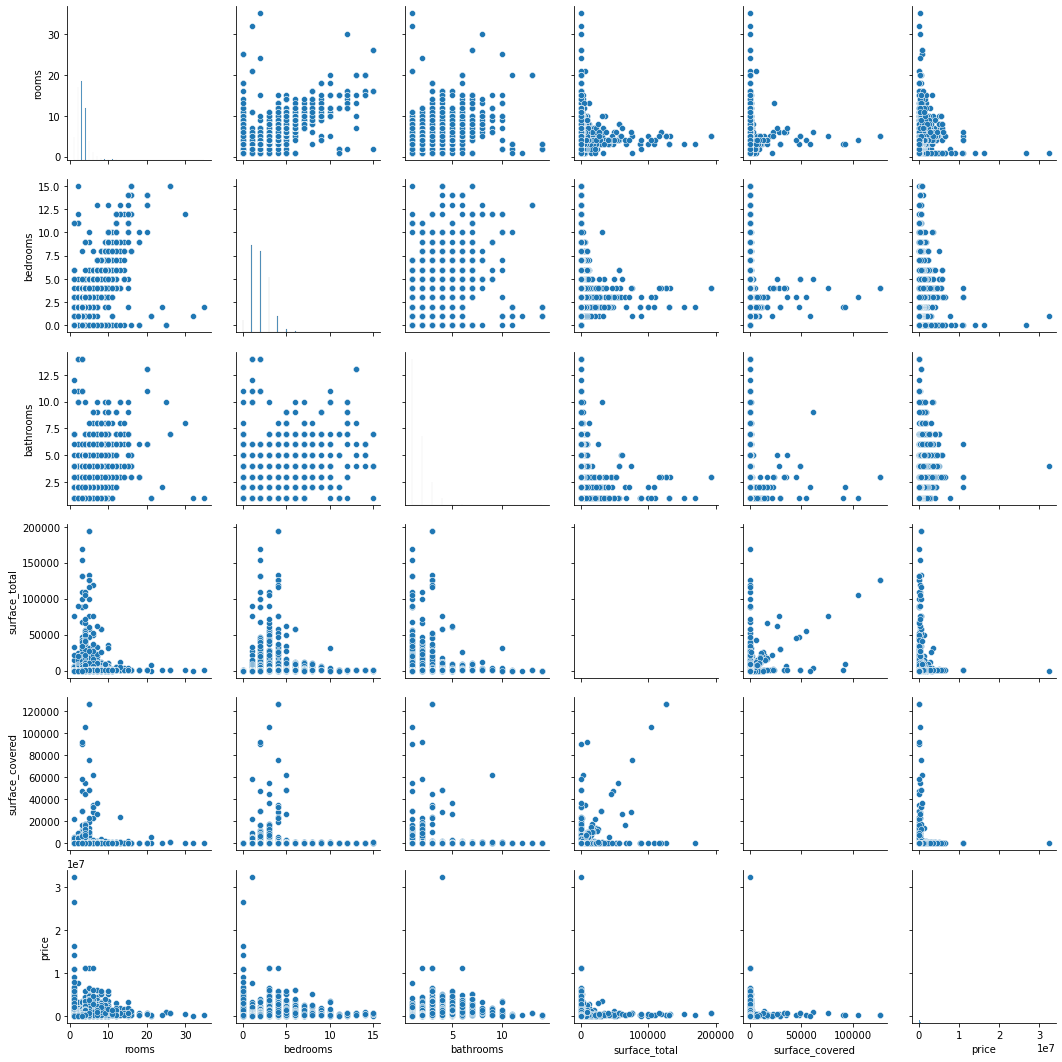

In [6]:
sns.pairplot (df.drop(columns={'lat', 'lon'}))

plt.show()

##### Datos estadísticos generales

In [7]:
df.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,136735.000000,136701.000000,146660.000000,146660.000000,140703.000000,126133.000000,125046.000000,1.466600e+05
mean,-34.604896,-58.465304,3.079817,1.983240,1.599994,216.872888,112.818011,2.412211e+05
std,0.468428,0.486190,1.416352,1.151304,0.889324,2037.606649,916.857584,3.185195e+05
min,-35.318457,-180.000000,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,-34.627667,-58.504012,2.000000,1.000000,1.000000,52.000000,47.000000,1.110000e+05
50%,-34.600943,-58.443262,3.000000,2.000000,1.000000,78.000000,68.000000,1.660000e+05
75%,-34.574600,-58.407586,4.000000,3.000000,2.000000,140.000000,108.000000,2.650000e+05
max,85.051129,-57.805832,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


##### Primera limpieza
Se eliminarán columnas que no serán utilizadas.

In [8]:
df = df.drop(columns={'start_date',
                       'end_date',
                       'created_on',
                       'l1',
                       'currency',
                       'title',
                       'description',
                       'operation_type'})

##### Filtrado de Region y Tipo de Propiedad

A los efectos de poder contrastar mejoras en el rendimiento respecto a lo efectuado en el **Sprint Project 1** se mantendrá la misma región y propiedad usadas en el mismo.
Además se mantendrán los límites para `surface_total` y `price`.


In [9]:
#Columnas a utilizar
columnas = ["rooms", 
            "bedrooms", 
            "bathrooms", 
            "surface_total", 
            "surface_covered", 
            "price",
            "property_type",
            "l3",
            'lat','lon']

In [10]:
df= df.loc[((df["l2"]== "Capital Federal")&
        (df["property_type"].isin(["PH","Casa","Departamento"]))&
        (df["surface_total"].between(15,1000)) & (df["price"]<= 4000000)),  columnas].dropna().reset_index(drop =True)

In [11]:
df.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,l3,lat,lon
0,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,San Cristobal,-34.605880,-58.384949
1,2.0,1.0,2.0,70.0,58.0,159000.0,PH,Boedo,-34.624056,-58.412110
2,2.0,1.0,1.0,45.0,45.0,125000.0,PH,Palermo,-34.593569,-58.427474
3,2.0,1.0,1.0,85.0,50.0,295000.0,PH,Palermo,-34.581294,-58.436754
4,2.0,1.0,1.0,56.0,56.0,150000.0,PH,Villa Crespo,-34.593779,-58.441239


In [12]:
df.shape

(76771, 10)

---

# Transformación de Datos
<a id='transf'></a>

Cargados y rápidamente visualizados los datos podemos tener una primera idea para hacer criteriosamente una elección de las transformaciones que se deberán aplicar.

## a. Elección de Transformaciones
<a id='transf_eleccion'></a>

Podemos decir que los "*Big Hero 6*" de la *Ingeniería de Atributos* en el preprocesamiento de datos son:

1. Tratamiento de datos **faltantes**.
2. Detección y tratamiento de **Outliers**.
3. **Codificación** de variable categóricas.
4. **Escalado/Normalización** de datos.
5. **Reducción de Dimensionalidad**.
6. Incorporación de **atributos** (**polinómicos**).

Buscaremos implementar aquí de la **1** a la **4**. La **5** y la **6** se incorporarán en la sección [7. Adicional](#Extra).

* Por contar con un *conocimiento previo* del dataset a partir del *sprint project 1*, sabemos que el mismo cuenta con **valores atípicos (outliers)** que dificultan  la correcta visualización de las distribuciones y posterior entrenamiento de modelos.
* Nos interesa trabajar sobre las variables **categóricas** `property_type` y `l3`, que expresan *tipo de propiedad* y *barrio* respectivamente, a fin de encontrar posibles correlaciones con los precios de venta. Aplicaremos para tal fin una **codificación** que nos permitirá utilizarlas en el entrenamiento de nuestros modelos.
* Sabemos también que existen distintos *órdenes de magnitud* entre los diferentes atributos del dataset; como por ejemplo, entre `rooms` y `surface_total`, por lo que aplicaremos un **escalado** o **normalización** de los mismos para llevarlos a las mismas magnitudes comparativas.


## b. Implementación de Transformaciones
<a id='transf_imple'></a>

### Tratamiento de datos faltantes

Para el tratamiento de los datos faltantes primero veremos la cantidad por atributo a fin de plantear una estrategia acorde para cada caso.

In [13]:
#Usaremos una copia del Dset por si hay que efectuar un rollback
df1= df

In [14]:
#Lo visualizaremos convenientemente como PORCENTAJE del total
print("*** Porcentaje de datos faltantes por atributo: ***")
(df1.isna().sum() / df1.shape[0])*100

*** Porcentaje de datos faltantes por atributo: ***


rooms              0.0
bedrooms           0.0
bathrooms          0.0
surface_total      0.0
surface_covered    0.0
price              0.0
property_type      0.0
l3                 0.0
lat                0.0
lon                0.0
dtype: float64

Podemos observar que el set de datos, bajo las **mismas** condiciones de filtrado implementadas en el **Sprint Project 1** **no** cuenta con valores faltantes en sus instancias.
* No se requiere, entonces, tratamiento alguno de datos faltantes.

### Detección y tratamiento de Outliers

Para la detección y tratamiento de outliers utilizaremos el **Criterio de los 3 Sigmas**. El mismo se describe de la siguiente manera:

$$ mínimo = ValorMedio - 3 x SD $$

$$ máximo = ValorMedio + 3 x SD $$

* Esto lo hacemos sabiendo por *antecedente* (del *Sprint Project 1*) que los atributos a tratar tienen una **distribución normal** (o aproximada).


In [15]:
#Todo valor fuera de los márgenes será convertido a NaN
for col in ['rooms','bedrooms','bathrooms','surface_total','surface_covered']:
  media = df1[col].mean()
  std = df1[col].std()
  outlier = (df1[col] > (media + (2.5*std))) | (df1[col] < (media - (2.5*std)))

  df1.loc[outlier, col] = np.nan

In [16]:
df1.isna().sum()

rooms              1201
bedrooms           1190
bathrooms          2520
surface_total      2449
surface_covered     146
price                 0
property_type         0
l3                    0
lat                   0
lon                   0
dtype: int64

In [17]:
#Imputación de valores outliers convertidos a NaN mediante la media
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
for col in ['surface_total','surface_covered']:
    imp.fit(df1[col].values.reshape(-1, 1))
    df1[col]=imp.transform(df1[col].values.reshape(-1, 1))
    
#Imputación de valores outliers convertidos a NaN mediante la mediana
imp = SimpleImputer(missing_values=np.nan, strategy='median')
for col in ['rooms','bedrooms','bathrooms']:
    imp.fit(df1[col].values.reshape(-1, 1))
    df1[col]=imp.transform(df1[col].values.reshape(-1, 1))

In [18]:
df1.isna().sum()

rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
l3                 0
lat                0
lon                0
dtype: int64

##### BoxPlots de atributos filtrados

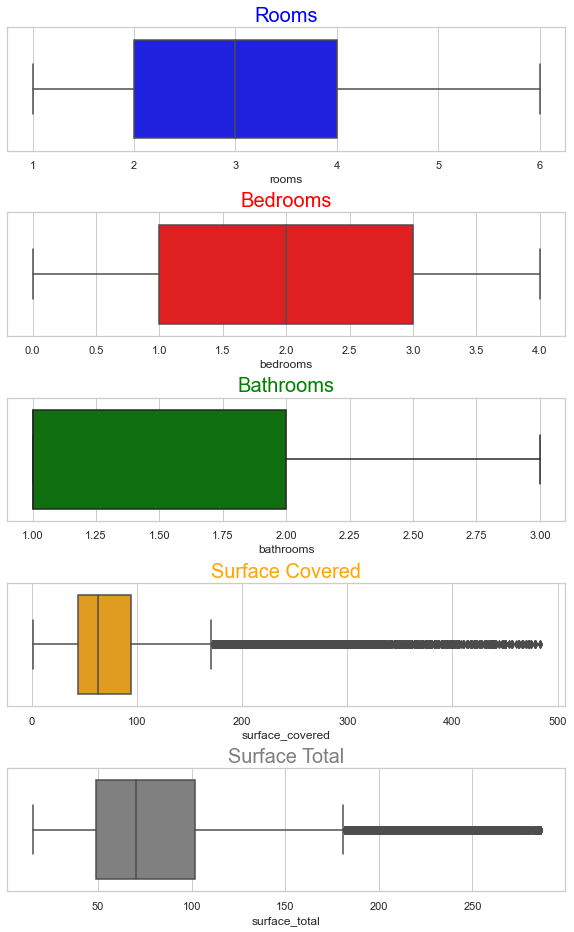

In [19]:
plt.figure(figsize=(10,15))
plt.subplots_adjust(left=0.125
                    , bottom=0.1
                    , right=0.9
                    , top=0.9
                    , wspace=0.2
                    , hspace=0.5)
sns.set(style="whitegrid")

plt.subplot(511)
sns.boxplot(x=df1['rooms'],
           color='blue')
plt.title("Rooms", color='blue',fontsize=20)

plt.subplot(512)
sns.boxplot(x=df1['bedrooms'],
           color='red')
plt.title("Bedrooms", color='red',fontsize=20)

plt.subplot(513)
sns.boxplot(x=df1['bathrooms'],
           color='green')
plt.title("Bathrooms", color='green',fontsize=20)

plt.subplot(514)
sns.boxplot(x=df1['surface_covered'],
           color='orange')
plt.title("Surface Covered", color='orange',fontsize=20)

plt.subplot(515)
sns.boxplot(x=df1['surface_total'],
           color='gray')
plt.title("Surface Total", color='gray',fontsize=20)

plt.show()

### Codificación de variable categóricas
<a id='codificacion'></a>

A continuación codificaremos las variables *categóricas* a fin de poder utilizarlas de manera más efectiva en la alimentación de un modelo de ML.

Previo a ello debemos identificar si nuestras variables categóricas son del tipo **ORDINAL** o **NOMINAL**.
Tenemos entonces:
* `l3` (*barrio*): Nominal, no existe una relación de orden.
* `property_type`: Nominal, no existe una relación de orden.

In [20]:
#Primero crearemos una copia del dataframe anterior
df2 = df1
#Segundo cambiaremos el nombre de l3' por 'barrio'
df2.rename(columns={'l3':'barrio'}, inplace=True)

Exploremos las variables categóricas:

In [21]:
# Variable 'barrio'
df2['barrio'].value_counts()

Palermo                 11157
Almagro                  6639
Villa Crespo             5819
Caballito                5528
Belgrano                 5410
Recoleta                 4939
Villa Urquiza            2883
Barrio Norte             2687
Balvanera                2276
Flores                   1948
Nuñez                    1777
Puerto Madero            1401
Colegiales               1272
Parque Centenario        1266
Villa Devoto             1249
Villa del Parque         1230
Saavedra                  940
Paternal                  939
San Cristobal             916
San Telmo                 900
Floresta                  811
Boedo                     742
Once                      734
Monserrat                 726
Retiro                    714
Parque Chacabuco          700
Barracas                  662
Villa Pueyrredón          658
Chacarita                 636
San Nicolás               629
Las Cañitas               601
Liniers                   583
Congreso                  582
Monte Cast

In [22]:
# Variable 'property_type'
df2['property_type'].value_counts()

Departamento    65329
PH               9334
Casa             2108
Name: property_type, dtype: int64

Para el **tipo de propiedad** se utilizará el método **One-Hot** dado que se trata únicamente de 3 tipos de variables.

In [23]:
df2 = pd.concat([df2,pd.get_dummies(df2["property_type"]).reset_index(drop= True)],
               axis=1)

In [24]:
df2.drop(columns='property_type',inplace=True)

In [25]:
df2.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,barrio,lat,lon,Casa,Departamento,PH
0,3.0,2.0,2.0,140.0,140.0,153000.0,San Cristobal,-34.605880,-58.384949,0,1,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,Boedo,-34.624056,-58.412110,0,0,1
2,2.0,1.0,1.0,45.0,45.0,125000.0,Palermo,-34.593569,-58.427474,0,0,1
3,2.0,1.0,1.0,85.0,50.0,295000.0,Palermo,-34.581294,-58.436754,0,0,1
4,2.0,1.0,1.0,56.0,56.0,150000.0,Villa Crespo,-34.593779,-58.441239,0,0,1


Para los barrios los dividiremos en grupos según el **valor del m^2**.
* Calcularemos el valor de metro cuadrado promedio por barrio y luego los agruparemos según ese valor.

In [26]:
df2["precio_m2"] =  df2.price /  df2.surface_total
df2.dropna(inplace= True)
df2.describe(percentiles=[0.05, 0.1, 0.5, 0.9, 0.95])

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,lat,lon,Casa,Departamento,PH,precio_m2
count,76771.000000,76771.000000,76771.000000,76771.000000,76771.000000,7.677100e+04,76771.000000,76771.000000,76771.000000,76771.000000,76771.000000,76771.000000
mean,2.925375,1.938102,1.426632,84.630567,80.967491,2.563026e+05,-34.598313,-58.434841,0.027458,0.850959,0.121582,3023.492045
std,1.115614,0.912120,0.639394,49.746988,58.497010,2.864284e+05,0.023385,0.035734,0.163416,0.356131,0.326805,2622.747499
min,1.000000,0.000000,1.000000,15.000000,1.000000,6.000000e+03,-34.696419,-58.530468,0.000000,0.000000,0.000000,21.818182
5%,1.000000,1.000000,1.000000,34.000000,32.000000,8.000000e+04,-34.636974,-58.500240,0.000000,0.000000,0.000000,1423.076923
10%,2.000000,1.000000,1.000000,39.000000,36.000000,9.250000e+04,-34.627870,-58.485358,0.000000,0.000000,0.000000,1709.090909
50%,3.000000,2.000000,1.000000,70.000000,63.000000,1.780000e+05,-34.598703,-58.432771,0.000000,1.000000,0.000000,2600.000000
90%,4.000000,3.000000,2.000000,155.000000,149.000000,4.500000e+05,-34.566206,-58.388511,0.000000,1.000000,1.000000,4051.282051
95%,5.000000,4.000000,3.000000,193.000000,197.000000,6.800000e+05,-34.557705,-58.378138,0.000000,1.000000,1.000000,5269.662921
max,6.000000,4.000000,3.000000,286.000000,483.000000,4.000000e+06,-34.535909,-58.353930,1.000000,1.000000,1.000000,58333.333333


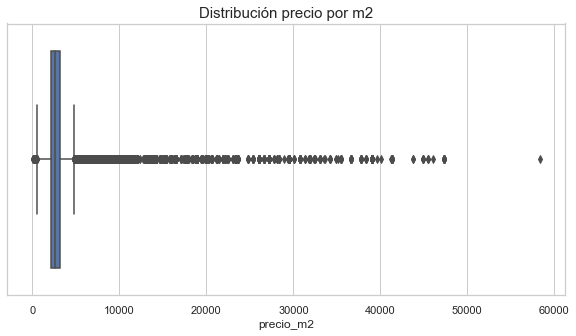

In [27]:
# Veamos la distribución de la columna
plt.figure(figsize=(10,5))
sns.boxplot(x=df2['precio_m2'])
plt.title("Distribución precio por m2", fontsize=15)
plt.show()

Se pueden observar algunos valores atípicos, asi que recortaremos entre el 10% y el 90% de los quintiles.

In [28]:
df2 = df2.loc[(df2.precio_m2 > df2.precio_m2.quantile(0.1)) & (df2.precio_m2 < df2.precio_m2.quantile(0.9)), :].reset_index(drop=True)

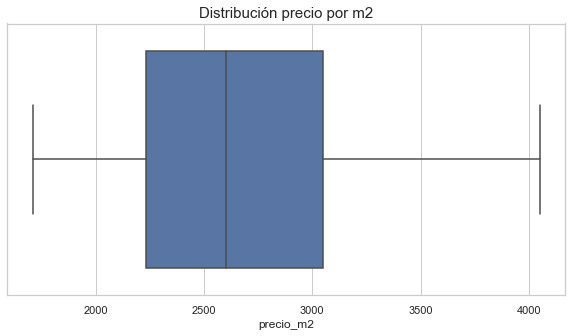

In [29]:
# Veamos la nueva distribucion
plt.figure(figsize=(10,5))
sns.boxplot(x=df2['precio_m2'])
plt.title("Distribución precio por m2", fontsize=15)
plt.show()

In [30]:
df2.shape

(61386, 13)

Con el dataset preparado tomaremos el precio **promedio** por barrio.

In [31]:
union=df2.groupby(['barrio'])['precio_m2'].agg(['mean'])
df2.merge(union,
          how= "left",
          left_on="barrio", 
          right_on="barrio")

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,barrio,lat,lon,Casa,Departamento,PH,precio_m2,mean
0,2.0,1.0,2.0,70.0,58.0,159000.0,Boedo,-34.624056,-58.412110,0,0,1,2271.428571,2333.780998
1,2.0,1.0,1.0,45.0,45.0,125000.0,Palermo,-34.593569,-58.427474,0,0,1,2777.777778,3021.560856
2,2.0,1.0,1.0,85.0,50.0,295000.0,Palermo,-34.581294,-58.436754,0,0,1,3470.588235,3021.560856
3,2.0,1.0,1.0,56.0,56.0,150000.0,Villa Crespo,-34.593779,-58.441239,0,0,1,2678.571429,2484.324719
4,2.0,1.0,1.0,70.0,70.0,159500.0,Villa Crespo,-34.600988,-58.433061,0,0,1,2278.571429,2484.324719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61381,3.0,2.0,1.0,84.0,84.0,178000.0,Palermo,-34.576573,-58.434394,0,0,1,2119.047619,3021.560856
61382,4.0,2.0,3.0,159.0,98.0,539000.0,Palermo,-34.581699,-58.433547,0,1,0,3389.937107,3021.560856
61383,4.0,3.0,3.0,175.0,111.0,570000.0,Palermo,-34.585355,-58.427194,0,0,1,3257.142857,3021.560856
61384,3.0,2.0,2.0,144.0,134.0,480000.0,Palermo,-34.585355,-58.427194,0,0,1,3333.333333,3021.560856


Hecho esto lo dividiremos y agruparemos los barrios en quintiles de a **20%** según su precio por metro cuadrado *promedio*:

In [32]:
df2["categoria_barrio"]  = pd.qcut(df2.precio_m2, 5)

In [33]:
df2.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,barrio,lat,lon,Casa,Departamento,PH,precio_m2,categoria_barrio
0,2.0,1.0,2.0,70.0,58.0,159000.0,Boedo,-34.624056,-58.412110,0,0,1,2271.428571,"(2142.857, 2450.98]"
1,2.0,1.0,1.0,45.0,45.0,125000.0,Palermo,-34.593569,-58.427474,0,0,1,2777.777778,"(2758.621, 3170.732]"
2,2.0,1.0,1.0,85.0,50.0,295000.0,Palermo,-34.581294,-58.436754,0,0,1,3470.588235,"(3170.732, 4050.725]"
3,2.0,1.0,1.0,56.0,56.0,150000.0,Villa Crespo,-34.593779,-58.441239,0,0,1,2678.571429,"(2450.98, 2758.621]"
4,2.0,1.0,1.0,70.0,70.0,159500.0,Villa Crespo,-34.600988,-58.433061,0,0,1,2278.571429,"(2142.857, 2450.98]"


Con esto asignaremos una categoría según el grupo donde caiga:

In [34]:
df2["categoria_barrio"].unique()

[(2142.857, 2450.98], (2758.621, 3170.732], (3170.732, 4050.725], (2450.98, 2758.621], (1709.21, 2142.857]]
Categories (5, interval[float64]): [(1709.21, 2142.857] < (2142.857, 2450.98] < (2450.98, 2758.621] < (2758.621, 3170.732] < (3170.732, 4050.725]]

In [35]:
df2["categoria_barrio"] = pd.cut(df2.precio_m2, 
       bins=[1709.21, 2143, 2451, 2759, 3171, 4051],
       labels= ["cat_1", "cat_2","cat_3","cat_4","cat_5"])

In [36]:
df2.drop(columns={'precio_m2','barrio'},inplace=True)
df2.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,lat,lon,Casa,Departamento,PH,categoria_barrio
0,2.0,1.0,2.0,70.0,58.0,159000.0,-34.624056,-58.412110,0,0,1,cat_2
1,2.0,1.0,1.0,45.0,45.0,125000.0,-34.593569,-58.427474,0,0,1,cat_4
2,2.0,1.0,1.0,85.0,50.0,295000.0,-34.581294,-58.436754,0,0,1,cat_5
3,2.0,1.0,1.0,56.0,56.0,150000.0,-34.593779,-58.441239,0,0,1,cat_3
4,2.0,1.0,1.0,70.0,70.0,159500.0,-34.600988,-58.433061,0,0,1,cat_2


Ahora sí, con los barrios divididos por categorías segun su precio promedio de m^2 procedemos a **codificar** el atributo:

In [37]:
df2 = pd.concat([df2,pd.get_dummies(df2["categoria_barrio"]).reset_index(drop= True)],
               axis=1)
df2.drop(columns='categoria_barrio', inplace=True)
df2.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,lat,lon,Casa,Departamento,PH,cat_1,cat_2,cat_3,cat_4,cat_5
0,2.0,1.0,2.0,70.0,58.0,159000.0,-34.624056,-58.412110,0,0,1,0,1,0,0,0
1,2.0,1.0,1.0,45.0,45.0,125000.0,-34.593569,-58.427474,0,0,1,0,0,0,1,0
2,2.0,1.0,1.0,85.0,50.0,295000.0,-34.581294,-58.436754,0,0,1,0,0,0,0,1
3,2.0,1.0,1.0,56.0,56.0,150000.0,-34.593779,-58.441239,0,0,1,0,0,1,0,0
4,2.0,1.0,1.0,70.0,70.0,159500.0,-34.600988,-58.433061,0,0,1,0,1,0,0,0


### Escalado/Normalización de datos

Por último efectuaremos una normalización de los datos para llevar todos los órdenes de magnitud a la misma escala comparativa.

Para llevar a cabo esta tarea utilizaremos `StandarScaler` de la librería `sklearn`.

In [38]:
#Primero crearemos una copia nueva en caso de necesitar un roll-back
df3 = df2

In [39]:
#Instanciamos, entrenamos y escalamos
ss = StandardScaler()
for col in ['rooms','bedrooms','bathrooms','surface_total','surface_covered','lat','lon']:
    ss.fit(df3[[col]])
    df3[col] = ss.transform(df3[[col]])
    

In [40]:
df3.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,lat,lon,Casa,Departamento,PH,cat_1,cat_2,cat_3,cat_4,cat_5
0,-0.761241,-0.965313,1.024728,-0.169676,-0.300281,159000.0,-1.258324,0.706514,0,0,1,0,1,0,0,0
1,-0.761241,-0.965313,-0.632209,-0.742284,-0.613776,125000.0,0.155250,0.248688,0,0,1,0,0,0,1,0
2,-0.761241,-0.965313,-0.632209,0.173889,-0.493201,295000.0,0.724401,-0.027850,0,0,1,0,0,0,0,1
3,-0.761241,-0.965313,-0.632209,-0.490337,-0.348511,150000.0,0.145510,-0.161492,0,0,1,0,0,1,0,0
4,-0.761241,-0.965313,-0.632209,-0.169676,-0.010901,159500.0,-0.188753,0.082187,0,0,1,0,1,0,0,0


##### Distribuciones estandarizadas

Veamos cómo quedaron las distribuciones de los atributos estandarizados:

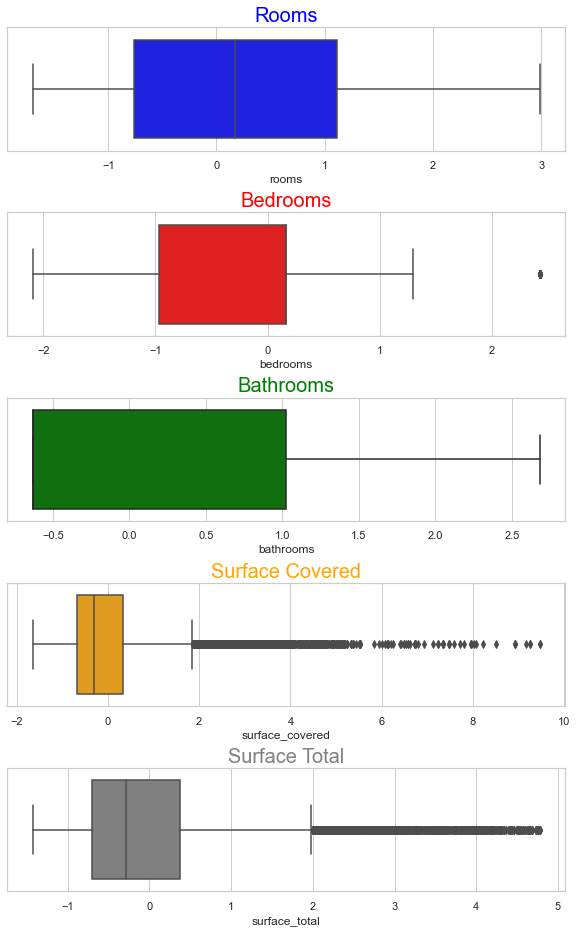

In [41]:
plt.figure(figsize=(10,15))
plt.subplots_adjust(left=0.125
                    , bottom=0.1
                    , right=0.9
                    , top=0.9
                    , wspace=0.2
                    , hspace=0.5)
sns.set(style="whitegrid")

plt.subplot(511)
sns.boxplot(x=df3['rooms'],
           color='blue')
plt.title("Rooms", color='blue',fontsize=20)

plt.subplot(512)
sns.boxplot(x=df3['bedrooms'],
           color='red')
plt.title("Bedrooms", color='red',fontsize=20)

plt.subplot(513)
sns.boxplot(x=df3['bathrooms'],
           color='green')
plt.title("Bathrooms", color='green',fontsize=20)

plt.subplot(514)
sns.boxplot(x=df3['surface_covered'],
           color='orange')
plt.title("Surface Covered", color='orange',fontsize=20)

plt.subplot(515)
sns.boxplot(x=df3['surface_total'],
           color='gray')
plt.title("Surface Total", color='gray',fontsize=20)

plt.show()

##### Matriz de correlación
Para terminar con el preprocesamiento de datos veamos cómo quedó la matriz de correlaciones:

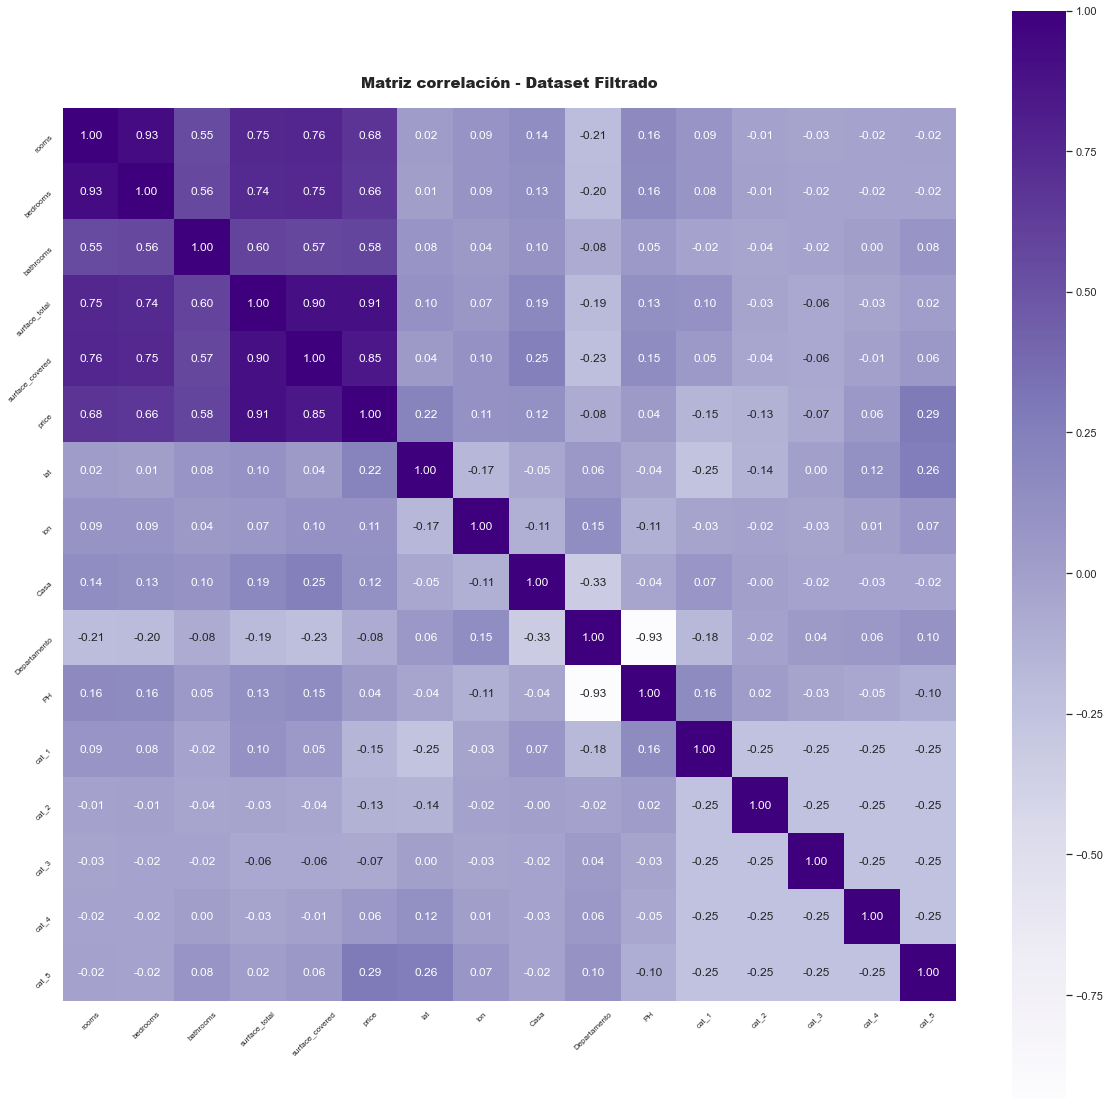

In [42]:
corr_df3 = df3.corr() #Creamos la matriz de correlación

plt.figure(figsize=(20,20))#Tamaño de gráfico                                                     

sns.heatmap(corr_df3   #Mapa de calor hecho a partir de la matriz de correlación
            , cbar = True
            , square = True
            , annot=True
            , fmt= '.2f'
            #, annot_kws={'size': 15}
            , cmap= 'Purples')

plt.xticks(rotation = 45, fontsize = 8)      #Etiquetas a 45 grados
plt.yticks(rotation = 45, fontsize = 8)

plt.title ("Matriz correlación - Dataset Filtrado"       #Título del gráfico
          ,fontsize = 15
          ,fontweight = 'black'
          ,pad = 20)

plt.show()

## c. ML - Reentrenamiento de Árbol de Decisión
<a id='reentre'></a>

Para el **Sprint Project 1** se utilizó de *benchmark* un modelo de **árbol de decisión** de **profundidad = 1** cuyos valores de evaluación dieron:
<table>
  <tr>
    <th>Tipo de Modelo</th>
    <th>Hiper-parámetros</th>
    <th>Variables X</th>
    <th>RMSE (test)</th>
    <th>Overfiting</th>
  </tr>
  <tr>
    <td>Benchmark</td>
    <td>Profundidad = 1</td>
    <td>2</td>
    <td>~230258</td>
    <td>No</td>
  </tr>
 </table>

Reentrenaremos este mismo modelo y observaremos su nuevo desempeño.
* Cabe aclarar, como mencionamos al principio, que para el **Sprint Project 1** se utilizaron *únicamente* los tipos de propiedad "*PH*", "*Casa*" y "*Departamento*" de la region de *Capital Federal*.

In [43]:
#1. Variables predictoras y variable a predecir
X = df3.drop(columns='price')
y = df3['price']
#2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [44]:
#3. Instanciamos el modelo
tree_bm = DecisionTreeRegressor(max_depth = 1)
#4. Entrenamos
tree_bm.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [45]:
#5. Predecimos y guardamos resultados
y_test_pred = tree_bm.predict(X_test)
y_train_pred = tree_bm.predict(X_train)

### Evaluación de Desempeño

In [46]:
#6. Evaluamos el modelo
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))               #Obtenemos la raiz cuadrada del MSE y lo guardamos
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print ("\n 🕵️ RAÍCES DEL ERROR CUADRÁTICO PROMEDIO:\n")
print("🛆Conjunto de ENTRENAMIENTO: ", rmse_train)
print("🛆Conjunto de TESTEO: ", rmse_test)


 🕵️ RAÍCES DEL ERROR CUADRÁTICO PROMEDIO:

🛆Conjunto de ENTRENAMIENTO:  86492.71248824667
🛆Conjunto de TESTEO:  86264.01979201753


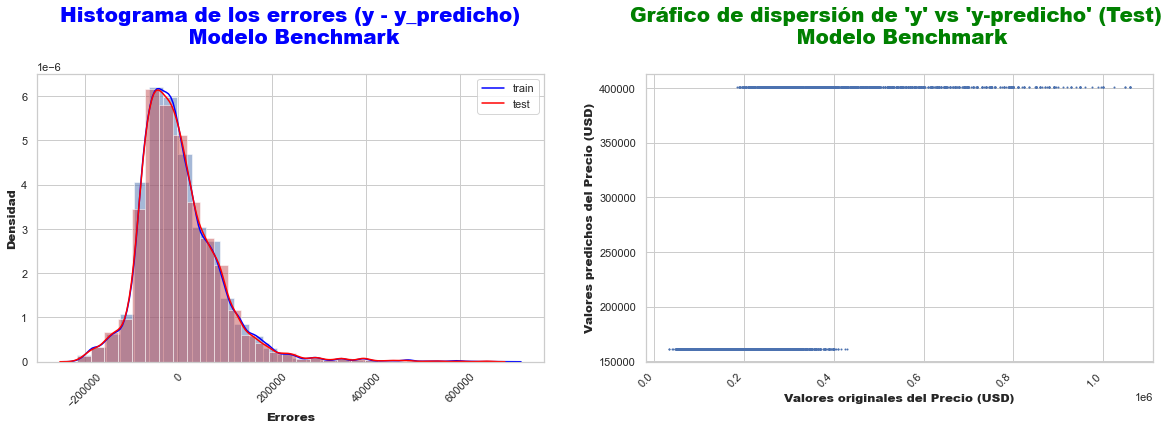

In [47]:
# 7. Distribución de errores

plt.figure (figsize= (20,5)) 
plt.subplots_adjust(left=0.125
                    , bottom=0.1
                    , right=0.9
                    , top=0.9
                    , wspace=0.2
                    , hspace=0.5)

## GRÁFICO DE HISTOGRAMA ##

plt.subplot(121)

plt.hist(y_train - y_train_pred,
         bins = 30,
         alpha=0.5,
         density=True,
         color= 'b')
plt.hist(y_test - y_test_pred,
         bins = 30,
         alpha=0.5,
         density=True,
         color= 'r')

sns.kdeplot(y_train - y_train_pred,
             label = 'train',
             color='blue',
             alpha=0.3)
sns.kdeplot(y_test - y_test_pred,
             label = 'test',
             color='red',
             alpha=0.3)

# Etiquetas de ejes y título

plt.title ("Histograma de los errores (y - y_predicho)\n Modelo Benchmark"   #Título del gráfico
          ,fontsize = 20
          ,fontweight = 'black'
          ,color= 'blue'
          ,pad = 30)

plt.xlabel("Errores", fontweight = "black", fontsize = 12)
plt.xticks(rotation = 45)

plt.ylabel("Densidad", fontweight = "black", fontsize = 12)
plt.legend()


## GRÁFICO DE DISPERSIÓN ##


plt.subplot(122)

plt.scatter(y_test, y_test_pred, s=1) 

# Etiquetas de ejes y título
plt.title ("Gráfico de dispersión de 'y' vs 'y-predicho' (Test) \n Modelo Benchmark"   #Título del gráfico
           ,fontsize = 20
           ,fontweight = 'black'
           ,color= 'green'
           ,pad = 30)
plt.xticks(rotation = 45, horizontalalignment="right")
plt.xlabel("Valores originales del Precio (USD)", fontweight = "black", fontsize = 12)

plt.ylabel("Valores predichos del Precio (USD)", fontweight = "black", fontsize = 12)

plt.show()

### Observaciones

Realmente se ve una **mejora significativa** respecto al modelo del **Sprint Project 1**. Podemos notar la diferencia que hace el preprocesamiento de los datos en el desempeño final de los modelos alimentados con ellos.
Estos valores pueden ser mejorados aún mas ya que:
* Se puede optimizar el modelo.
* Se pueden elegir modelos de predicción más avanzados.
* Se pueden aplicar técnicas avanzadas de preprocesamiento, como *Reducción de Dimensionalidad* y *Atributos Polinómicos*.

---

# Modelos Avanzados
<a id='ML_Adv'></a>

## Elección de Modelos
<a id='ML_Adv_elec'></a>

Para la implementación de modelos avanzados se aplicarán:
1. **Regresión** con **regularización Lasso**
2. **Ensamble** del tipo **Random Forest Regressor**.

**NOTA:** Los atributos polinómicos serán adicionados en la sección [7.1 Nuevas Transformaciones](#extra_tranf_data).


### Modelo 1: Regularización Lasso

Se eligió la regularización **Lasso** por sobre la *Ridge* ya que la misma "castiga" los atributos menos importantes **llevándolos a cero**.

In [48]:
#1. Instanciamos un modelo de Reg.Lasso
reg_lasso = Lasso(alpha = 1, #Elegimos 1 para probar, luego optimizaremos
                  max_iter=1000,
                  tol=0.0001,                  
                  normalize=True) 

In [49]:
#2. Entrenamos
reg_lasso.fit(X_train,y_train)

Lasso(alpha=1, normalize=True)

#### Evaluación

Raíz del error cuadrático medio en Train: 28776.092951916657
Raíz del error cuadrático medio en Test: 28769.229844304704


d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


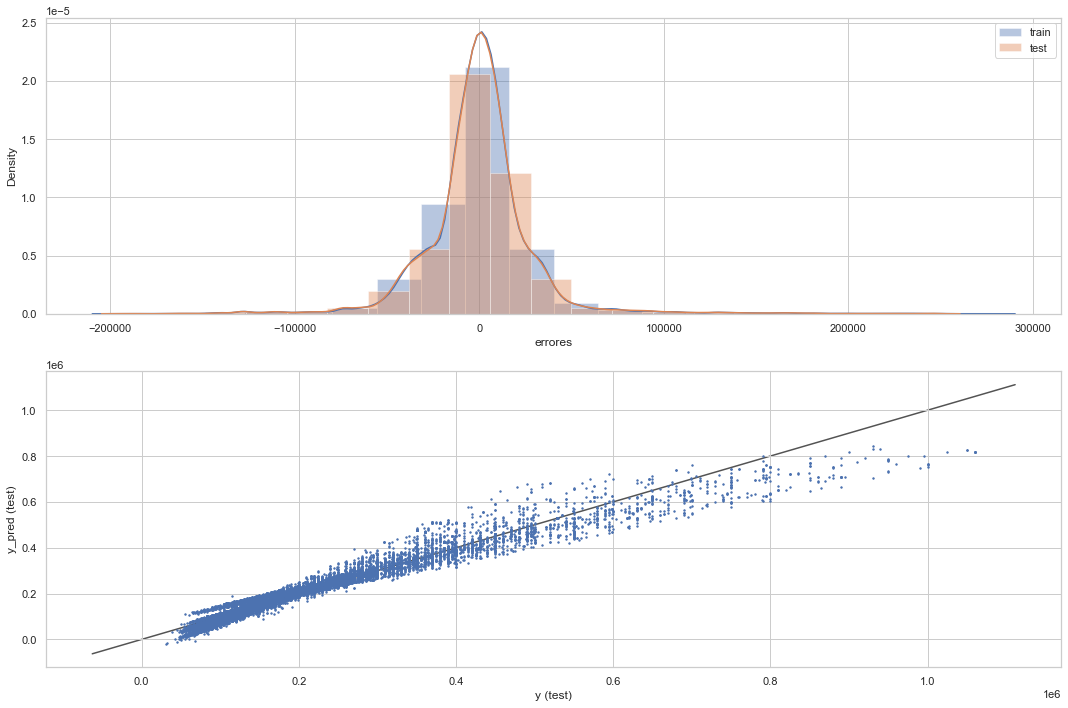

In [50]:
#5. Evaluamos el modelo mediante la función definida
evaluar_regresion(reg_lasso, X_train, X_test, y_train, y_test)

Podemos notar que:
* Los puntos tienen un agrupamiento tendiente a la regresión lineal.
* Se redujo *considerablemente* el error con respeco al modelo **benchmark**.
* No parece existir un **sobreajuste** notable por parte del modelo.

De todas maneras, en la sección [4.2](#ML_Adv_opti) nos encargaremos de la optimización de los hiperparámetros del mismo.

### Modelo 2: Random Forest Regressor

Para este segundo modelo regresor se seleccionó un **ensamble** del tipo **bosque aleatorio**.

In [51]:
# 1. Instanciamos el modelo (parámetros base)
rnd_forest = RandomForestRegressor()
# En la siguiente sección serán optimizados

In [52]:
# 2. Entrenamos
rnd_forest.fit(X_train, y_train)

RandomForestRegressor()

#### Evaluación

Raíz del error cuadrático medio en Train: 4651.926479241986
Raíz del error cuadrático medio en Test: 9863.965337761952


d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


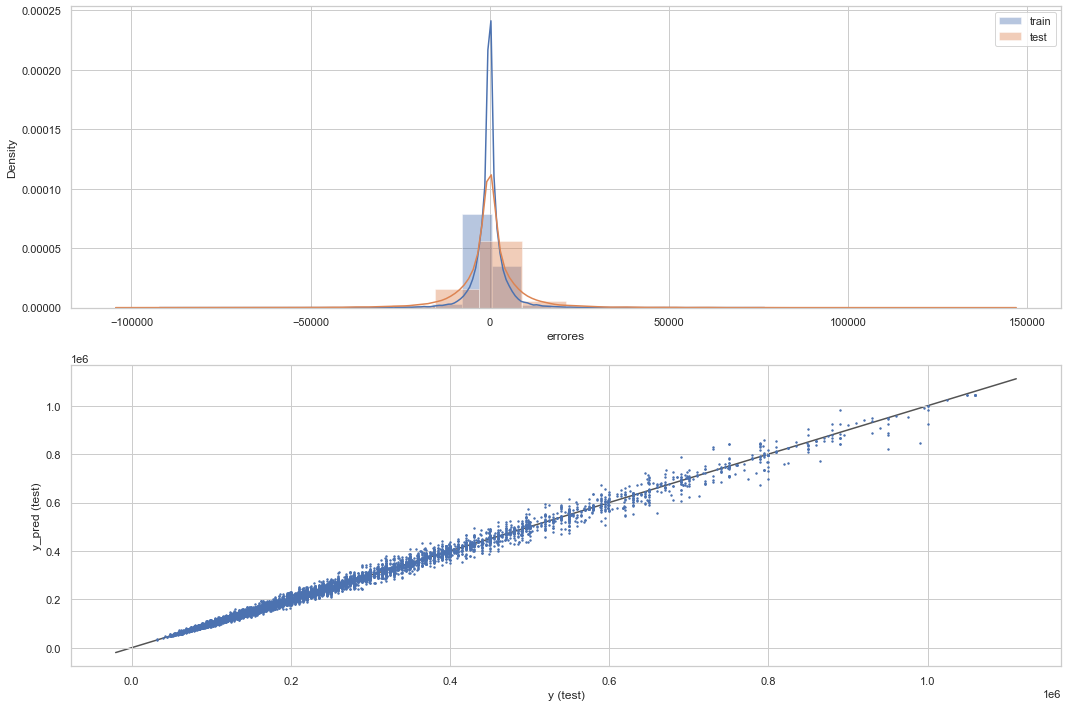

In [53]:
#3. Evaluamos el modelo mediante la función definida
evaluar_regresion(rnd_forest, X_train, X_test, y_train, y_test)

##### Ranking de importancia de atributos en el modelo

In [54]:
pd.DataFrame({'feature':X_train.columns, 'importancia': rnd_forest.feature_importances_}).sort_values('importancia', ascending=False)

,feature,importancia
3,surface_total,0.819878
14,cat_5,0.105260
10,cat_1,0.032494
13,cat_4,0.018465
4,surface_covered,0.013098
5,lat,0.002679
11,cat_2,0.002531
6,lon,0.002449
12,cat_3,0.001821
2,bathrooms,0.000418


Observando la evaluación notamos que:
* El modelo mejora increíblemente con respecto al *benchmark*.
* Su RMSE es el menor de los modelos enternados hasta aquí.
* Sin embargo, si observamos los RMSE `test` vs `train` podemos notar que una diferencia que lleva a pensar que el mismo está **sobreajustando**.

Al igual que el modelo de Lassio, en la sección [4.2](#ML_Adv_opti) nos encargaremos de la optimización de los hiperparámetros.

## Optimización de Hiperparámetros
<a id='ML_Adv_opti'></a>

En esta sección se tomarán los dos modelos elegidos en [4. Modelos Avanzados](#ML_Adv) para buscar **optimizarlos**.
Para ello se eligieron las dos siguiente técnicas:
* **Validación Cruzada**: es un proceso similar al *train-test*, donde se evalúa y valida mediante el entrenamiento de varios modelos con **subconjuntos** de los datos de entrada disponibles y su **evaluación** en el subconjunto complementario de los datos.
* **Random-Search**: se decidió por sobre *grid-search* ya que el espacio de combinaciones se explora de manera más eficiente, beneficiando a los hiperparámetros más importantes.

### Random Search con CV

#### RS-CV Regularización Lasso


In [55]:
#1. Definimos una lista de los parámetros a probar/optimizar
param_lasso = {'alpha':uniform()}

In [56]:
#2. Efectuamos el Random Search (Incluye CV)
lasso_CV = RandomizedSearchCV(estimator=reg_lasso,
                              param_distributions=param_lasso,
                              n_iter=100,
                              random_state=42, cv=5)

In [57]:
#3. Entrenamos el nuevo modelo
lasso_CV.fit(X_train, y_train)

d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130876371147.59766, tolerance: 55085012372.118706
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131426178195.5664, tolerance: 55229978972.15579
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131319596437.44531, tolerance: 55049946513.9216
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascienc

d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136999354664.80469, tolerance: 55229978972.15579
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136865638596.28906, tolerance: 55049946513.9216
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137684216471.85938, tolerance: 55131763169.06778
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascienc

d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141113985427.83203, tolerance: 55049946513.9216
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141933628055.64453, tolerance: 55131763169.06778
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139158115296.63672, tolerance: 54629469893.88063
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascienc

RandomizedSearchCV(cv=5, estimator=Lasso(alpha=1, normalize=True), n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023B83DE7700>},
                   random_state=42)

d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Raíz del error cuadrático medio en Train: 28749.742708338657
Raíz del error cuadrático medio en Test: 28743.44669195473


d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


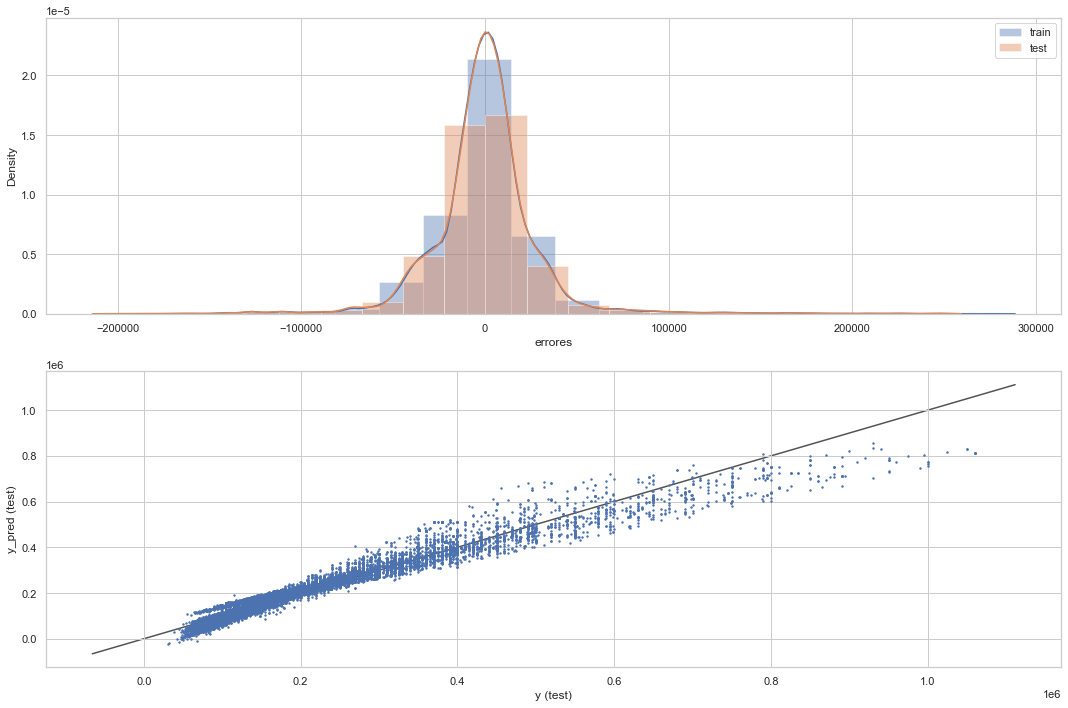

In [58]:
#5. Probemos entonces ahora predecir en los datos del test
evaluar_regresion(lasso_CV, X_train, X_test, y_train, y_test)

**Observaciones**:
* Podemos ver que el valor óptimo de hiperparámetro hallado para el modelo fue:
    * Alpha = 0.005522117123602399
* Respecto a la evaluación observamos que no hubieron practicamente mejoras respecto al modelo original.

Analicemos para este último punto el valor de los coeficientes tanto **antes** como **después** de la optimización:

In [59]:
#Coeficientes antes y después de la optimización
print("Coeficientes ANTES de optimización:\n")
print(reg_lasso.coef_)
print("\n Coeficientes DESPUÉS de optimización:\n")
print(lasso_CV.best_estimator_.coef_)

Coeficientes ANTES de optimización:

[ 1.50800959e+03 -2.23044806e+03  3.07897246e+00  1.07498665e+05
  1.21239429e+04  0.00000000e+00  1.16719756e+03 -3.30597129e+04
  9.94546214e+03 -0.00000000e+00 -5.57428185e+04 -2.14729851e+04
 -0.00000000e+00  2.44047319e+04  7.05814238e+04]

 Coeficientes DESPUÉS de optimización:

[ 4.08468124e+03 -5.21058410e+03  2.00718444e+02  1.07729285e+05
  1.23659445e+04 -1.58914702e+02  1.25532274e+03 -3.53554088e+04
  1.02417299e+04 -8.55436945e+01 -8.64918755e+04 -5.21576075e+04
 -3.02700249e+04 -5.48669684e+03  4.06091500e+04]


Se puede observar que con la optimización se castiga menos a los valores de menor importancia, sin embargo el desempeño no ve una mejora reflejada. Esto se puede deber a que necesitemos aplicar otras técnicas en el **preprocesamiento** para mejorar el entrenamiento.
* Se abordará este tema en la sección [7.1 Nuevas Transformaciones](#extra_tranf_data) al buscar agregar nuevos **atributos polinómicos**.

#### RS-CV Random Forest Regressor

In [60]:
#1. Definimos una lista de los parámetros a probar

# Número de árboles en el bosque
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
# Cantidad de atributos a considerar por particion
max_features = ['auto']
# Máxima profundidad de árboles
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)

# Creamos la lista

param_rnd_forest = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth}

In [61]:
#2. Efectuamos el Random Search (Incluye CV)
rnd_forest_CV = RandomizedSearchCV(estimator= rnd_forest,
                                   param_distributions= param_rnd_forest,
                                   n_iter=10,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   scoring    = 'neg_root_mean_squared_error',
                                   return_train_score = True,
                                   n_jobs= -1)

In [62]:
#3. Entrenamos el nuevo modelo
rnd_forest_CV.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110, None],
                                        'max_features': ['auto'],
                                        'n_estimators': [50, 155, 261, 366, 472,
                                                         577, 683, 788, 894,
                                                         1000]},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=2)

In [63]:
#4. Veamos los resultados obtenidos
print("Mejores parametros: "+str(rnd_forest_CV.best_params_))
print("Mejor Score: "+str(rnd_forest_CV.best_score_)+'\n')

Mejores parametros: {'n_estimators': 683, 'max_features': 'auto', 'max_depth': 26}
Mejor Score: -10442.869006836143



Raíz del error cuadrático medio en Train: 4608.619192552013
Raíz del error cuadrático medio en Test: 9819.595486216382


d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


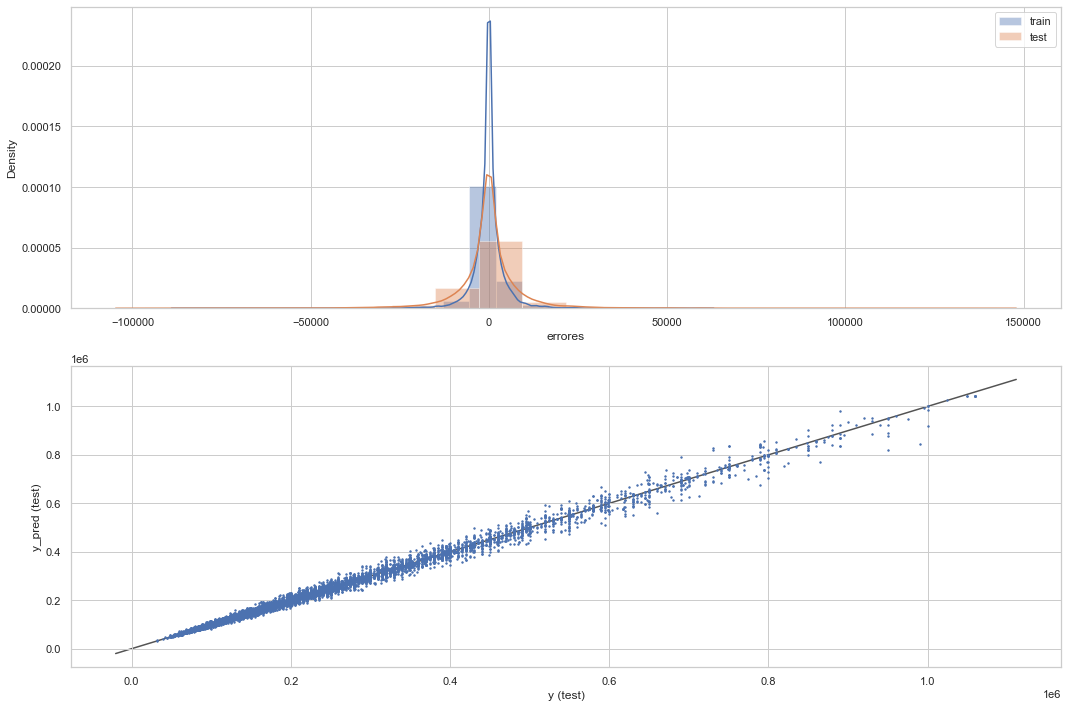

In [64]:
#5. Probemos entonces ahora predecir en los datos del test
evaluar_regresion(rnd_forest_CV, X_train, X_test, y_train, y_test)

Vemos que con los "mejores" parámetros elegidos por la Random-Search el modelo sigue **sobreajustado**.

Para solucionar esto veamos la tabla de estimadores:

In [65]:
#Agregaremos una columna para ver la diferencia enter RMSE train-test
estim_rnd_forest_CV=pd.DataFrame(rnd_forest_CV.cv_results_)
estim_rnd_forest_CV["DIF_train_test"] = estim_rnd_forest_CV["mean_train_score"] - estim_rnd_forest_CV["mean_test_score"]
#Ordenamos de mayor a menor
estim_rnd_forest_CV=estim_rnd_forest_CV.sort_values('DIF_train_test', ascending = True)

Tenemos entonces que el estimador que presenta **menos sobreajuste** y, por lo tanto el que eligiremos, es:

In [66]:
estim_rnd_forest_CV[{'param_n_estimators','param_max_features','param_max_depth'}].head(1)

,param_n_estimators,param_max_features,param_max_depth
2,472,auto,5


In [67]:
# Entrenamos el modelos con dichos ajustes
nuevo_rnd_forest= RandomForestRegressor(n_estimators=472,
                                        max_depth=5,
                                        max_features='auto')
nuevo_rnd_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=472)

Raíz del error cuadrático medio en Train: 23458.255759045696
Raíz del error cuadrático medio en Test: 23689.336765103846


d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


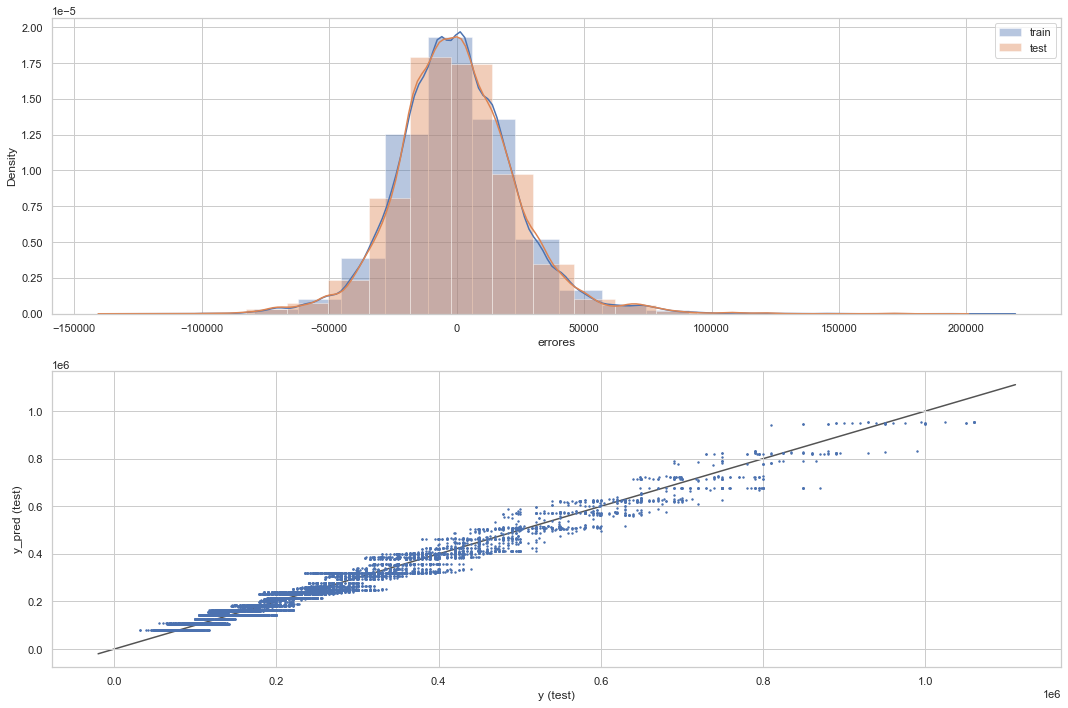

In [68]:
#Evaluamos el nuevo modelo
evaluar_regresion(nuevo_rnd_forest, X_train, X_test, y_train, y_test)

**Observaciones**:
* Si bien los parámetros encontrados por la *Random-Search* disminuyeron *considerablemente* el error, dicho modelo seguí **sobreajustando**.
* El nuevo modelo tiene mayor **RMSE** pero **no** sobreajusta. Además, así y todo mejora con respecto a la regresion Lasso.
* Podemos ver entonces que los hiperparámetros óptimos hallados para el modelo son:
    * n_estimators = *472*
    * max_features = *auto*
    * max_depth = *5*

## Comparación de Desempeños
<a id='ML_Adv_compa'></a>

La siguiente tabla resumirá los valores obtenidos de los 5 modelos de ML a fin de poder comparlos entre si:

<table>
  <tr>
    <th>Modelo</th>
    <th>Hiperparámetros</th>
    <th>RMSE train</th>
    <th>RMSE test</th>
    <th>Overfitting?</th>
  </tr>
  <tr>
    <td>Benchmark</td>
    <td>Profundidad = 1</td>
    <td>~86492</td>
    <td>~86264</td>
    <td>No</td>
  </tr>
  <tr>
    <td>Lasso</td>
    <td>alpha = 1</td>
    <td>~28776</td>
    <td>~28769</td>
    <td>No</td>
  </tr>
     <tr>
    <td>Random Forest Reg</td>
    <td>Default</td>
    <td>~4662</td>
    <td>~9863</td>
    <td>Sí</td>
  </tr>
     <tr>
    <td>Lasso CV</td>
    <td>alpha = 0.005522117123602399</td>
    <td>~28749</td>
    <td>~28743</td>
    <td>No</td>
  </tr>
     <tr>
    <td>Random Forest Reg CV</td>
    <td>n_estimators = 683,
        max_features = 'Auto',
        max_depth = 26</td>
    <td>~4602</td>
    <td>~9817</td>
    <td>Sí</td>
  </tr>
    <tr>
    <td>Nuevo Random Forest Reg</td>
    <td>n_estimators = 472,
        max_features = 'Auto',
        max_depth = 5</td>
    <td>~23582</td>
    <td>~23808</td>
    <td>No</td>
  </tr>
</table>

Podemos observar entonces, a partir de la información presentada, que el modelo que tuvo **mejor desempeño** (y por lo tanto, el elegido) es el **Nuevo Random Forest Regressor**.

* Este modelo logró bajar drásticamente el *RMSE* con respecto al benchmark establecido en [3.3](#reentre).
* Los valores de **RMSE** para `train` y `test` se encuentran en el mismo orden, por lo que el modelo **generaliza correctamente**.
* Por último, se trata de un modelo sencillo (y relativamente rápido) de entrenar, optimizar e implementar.

---

# Interpretación de Modelos
<a id='ML_Inter'></a>

## Preguntas Interpretativas
<a id='ML_Inter_Preg'></a>
Las siguientes preguntas y respuestas buscan profundizar el análisis sobre lo efectuado en las secciones anteriores.

##### ¿Qué variables fueron relevantes para el modelo para hacer una predicción?¿Cuáles no?

Para saber la importancia de los atributos en la predicción del modelo elegido utilizaremos el método `feature_importances_`

In [69]:
#Importancia de cada atributo en la predicción del modelo elegido

pd.DataFrame({'feature':X_train.columns, 'importancia': 100*nuevo_rnd_forest.feature_importances_}).sort_values('importancia', ascending=False)

,feature,importancia
3,surface_total,84.367576
14,cat_5,10.988421
10,cat_1,3.072871
13,cat_4,0.903590
4,surface_covered,0.657601
11,cat_2,0.009862
5,lat,0.000071
6,lon,0.000009
0,rooms,0.000000
1,bedrooms,0.000000


Podemos ver que:
* `surface_total` es, con mucha diferencia, la variable de mayor importancia utilizada en la predicción.
* Algunas categorías de barrios (segun su precio por metro cuadrado) componen el 2do bloque de mayor importancia en la predicción del modelo.
* Los atributos correspondientes al *tipo de propiedad* y los relacionados a la *cantidad de ambientes* (baños, habitaciones, etc) componen aquellos *menos* utilizados en la determinación de la predicción.


Tomemos algunos árboles del ensamble y observemos si este patrón de importancia se repite:

In [70]:
print("Estimador nro.5:")
pd.DataFrame({'feature':X_train.columns, 'importancia': 100*rnd_forest_CV.best_estimator_.estimators_[5].feature_importances_}).sort_values('importancia', ascending=False)

Estimador nro.5:


,feature,importancia
3,surface_total,82.875371
14,cat_5,10.741271
10,cat_1,3.544719
13,cat_4,1.643744
5,lat,0.280046
6,lon,0.243323
12,cat_3,0.237824
4,surface_covered,0.195675
11,cat_2,0.111773
2,bathrooms,0.041937


In [71]:
print("Estimador nro.17:")
pd.DataFrame({'feature':X_train.columns, 'importancia': 100*rnd_forest_CV.best_estimator_.estimators_[17].feature_importances_}).sort_values('importancia', ascending=False)

Estimador nro.17:


,feature,importancia
3,surface_total,82.544507
14,cat_5,10.970441
10,cat_1,3.717199
13,cat_4,1.421274
5,lat,0.302307
11,cat_2,0.271145
6,lon,0.254453
12,cat_3,0.205159
4,surface_covered,0.190192
2,bathrooms,0.044257


In [72]:
print("Estimador nro.11:")
pd.DataFrame({'feature':X_train.columns, 'importancia': 100*rnd_forest_CV.best_estimator_.estimators_[11].feature_importances_}).sort_values('importancia', ascending=False)

Estimador nro.11:


,feature,importancia
3,surface_total,82.680814
14,cat_5,11.107903
10,cat_1,3.437066
13,cat_4,1.601703
5,lat,0.266207
6,lon,0.262020
11,cat_2,0.249787
4,surface_covered,0.194481
12,cat_3,0.066740
0,rooms,0.041882


Se puede observar entonces que entre los árboles del ensamble `surface_total` siempre ocupa lugares **poderantes** en la predicción de los modelos.

##### ¿En qué se diferencian esos árboles?¿Por qué?

Se diferencian en su ponderación de cada atributo. Recordemos que el método de ensamble genera numerosos arboles con los cuales luego, por puntuación o voto, elige los mejores resultados. 

Es por esta razón que los arboles individuales componentes del bosque siempre responderan de manera diferente, por que los inputs son tomados al azar y con reposición.

##### ¿Coincide con lo que esperabas a partir de tu experiencia con el dataset?


Efectivamente se esperaba una respuesta del modelo en el sentido obtenido. La experiencia previa con el dataset a partir del proyecto predecesor ya mostraba que las variables predictoras más fuertes fueron las mismas que las obtenidas en estos modelos.

## Distribución de Errores y Fallas
<a id='ML_Inter_err'></a>

##### ¿Cómo es la distribución de los errores?

Podemos observar las distribuciones propias para cada modelo bajo sus respectivas secciones en el apartado [4. Modelos Avanzados](#ML_Adv).
Todos los modelos presentan una distribución de errores **normal** o **cuasi-normal**.

##### ¿Dónde fallan los modelos?

Las fallas se encuentran principalmente en los valores extremos de `y`, ya sean muy bajos o muy altos.

##### ¿A qué crees que se debe?

Esto se debe principalmente a que estamos utilizando el **RMSE** como métrica de evaluación, la cual es **sensible** a los valores *atípicos*.

Aquellos valores donde la diferencia entre la *etiqueta* y lo *predicho* aumenta se ve asentuado por estar la métrica elevada al cuadrado.

---

# Cierre
<a id='cierre'></a>

## Conclusiones
<a id='Conclusiones'></a>

##### Metodología utilizada:

Si bien se observaron mejoras en la mayoría de los modelos entrenados, cabe reconocer que podrían optimizarse aún más.

Vemos que con unos pocos cambios el RMSE respondió inmediatamente con una disminución de su valor. En este punto se desean destacar los siguientes aspectos a mejorar:
* Profundizar con técnicas más complejas para el **preprocesamiento** de los datos:
    * Reducción de dimensionalidad.
    * Creación de nuevos atributos polinómicos.
    * Clusterización para identificación de relaciones.
* Junto con el punto anterior, re-optimizar el modelo de *random forest regressor* .
* Aplicar otros modelos con distintos algoritmos predictivos, como por ejemplo **XGBOOST**, que trabaja por **descenso por gradiente**.

Se tratará de aplicar algunas de estas mejoras en la [sección 7.](#extra)

---

# Adicional
<a id='extra'></a>

En esta sección buscaremos mejorar aún más el desempeño de los modelos mediante la aplicación de dos nuevas transformaciones de datos:
* Atributos Polinómicos.
* Reduccion de Dimensionalidad.

También aplicaremos una **clusterización** e intentaremos inferir a qué se deben las relaciones encontradas.

Por último, alimentaremos nuevamente un modelo para evaluar su nuevo desempeño.

## Nueva Transformación de Datos
<a id='extra_tranf_data'></a>

Primero, haremos una copia del último dataframe:

In [73]:
df4 = df3

### Atributos polinómicos

Aplicaremos esta técnica con la idea de mejorar el modelo de **Regresión Regularizada por Lasso**.

El modelo presenta **alto** sesgo y baja **varianza**, por lo que es recomendable adicionar más parámetros, disminuir la regularización y aplicar boosting. 

In [74]:
# 1. Instanciaremos un nuevo objeto para atributos polinómicos
poly = PolynomialFeatures(degree=3, include_bias=False,
                          interaction_only= False, order= 'C')

In [75]:
#2. Transformaremos tanto el conjunto de entrenamiento como de test
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

In [76]:
print("Atributos ANTES:   train ",X_train.shape[1],"   ; test", X_test.shape[1])
print("Atributos DESPUES: train ",X_train_new.shape[1],"  ; test", X_test_new.shape[1])

Atributos ANTES:   train  15    ; test 15
Atributos DESPUES: train  815   ; test 815


In [77]:
#3. Instanciemos un modelo Lasso con boosting
lasso_poly = Lasso(alpha = 0.005522117123602399,
                   max_iter=1000,
                   tol=0.0001,
                   normalize=True) 

ada_reg = AdaBoostRegressor(lasso_poly, #Modelo base a utilizar
                            n_estimators=50) #Cantidad de estimadores a generar


In [78]:
#4. Entrenamos
ada_reg.fit(X_train_new, y_train)

d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1261751880101.791, tolerance: 69835956715.86824
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3209248568279.462, tolerance: 91229141159.6135
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9975318958099.193, tolerance: 152713341686.14517
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\

d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134163790313720.22, tolerance: 197499004143.30972
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135030625683188.16, tolerance: 191860329231.97632
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135588517104136.0, tolerance: 188318442284.7421
  model = cd_fast.enet_coordinate_descent(
d:\Users\FRED-104\miniconda3\envs\datascie

AdaBoostRegressor(base_estimator=Lasso(alpha=0.005522117123602399,
                                       normalize=True))

Raíz del error cuadrático medio en Train: 23293.844131177026
Raíz del error cuadrático medio en Test: 24347.56530092901


d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


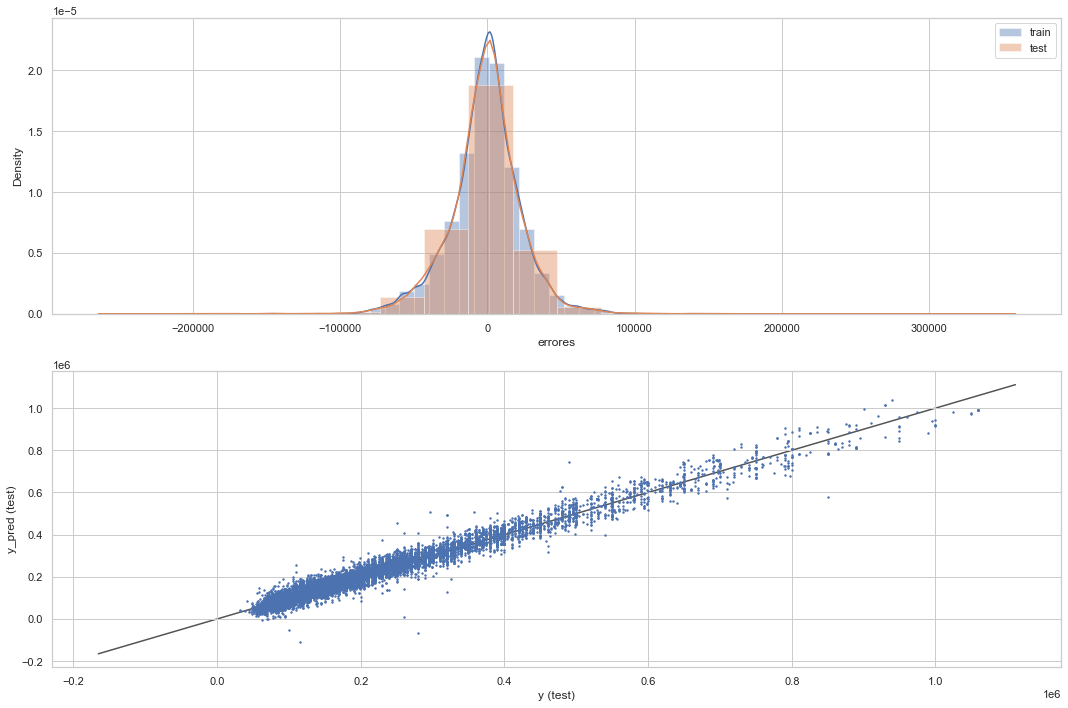

In [79]:
#5. Veamos el nuevo desempeño
evaluar_regresion(ada_reg, X_train_new, X_test_new, y_train, y_test)

* Podemos observar que aplicando estas nuevas técnicas logramos mejorar el desempeño del modelo.
* Generaliza bien, sin presentar **underfitting** o **overfitting**.

### Reducción de Dimensionalidad

Otra buena técnica de preprocesamiento es la llamada *reducción de dimensionalidad*, la cual busca transformar y llevar nuestro dataset a una versión "reducida" conteniendo aquellos datos de mayor relevancia.

Para este caso aplicaremos **Análisis de Componentes Principales** o **PCA**.

In [80]:
#1. Instanciamos un modelo PCA para el máximo de componentes principales
pca = PCA(n_components=815)

In [81]:
#2. Definimos los conjuntos de variables
X_pca = df4.drop(columns='price')
y_pca = df4['price']

In [82]:
#3. Aplicaremos también el polynomial features
X_nuevo = poly.fit_transform(X_pca)
# Aplicamos reducción de dimensionalidad
X_nuevo = pca.fit_transform(X_nuevo)
#Veamos los componentes generados
pca.components_

array([[ 0.01983901,  0.01902897,  0.01572794, ...,  0.        ,
         0.        ,  0.00125637],
       [-0.0204868 , -0.01954982, -0.02222141, ..., -0.        ,
        -0.        ,  0.00059752],
       [ 0.03100211,  0.03251965,  0.06378267, ..., -0.        ,
        -0.        , -0.00019885],
       ...,
       [-0.        , -0.01533802, -0.01626039, ..., -0.        ,
        -0.        ,  0.09140507],
       [ 0.        ,  0.06583261,  0.05018898, ...,  0.        ,
         0.        ,  0.00715922],
       [ 0.        , -0.02039191, -0.08624556, ...,  0.        ,
         0.        ,  0.03460866]])

In [83]:
#4. Con el nuevo conjunto hacemos un train-test
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_nuevo, y_pca, test_size = 0.3, random_state = 42)

Hecho esto, aplicaremos el conjunto para entrenar un modelo de *regresion Lasso* básico:

In [84]:
#5. Entrenamos el modelo
reg_pca=Lasso(alpha=1)
reg_pca.fit(X_train_pca, y_train_pca)

Lasso(alpha=1)

Raíz del error cuadrático medio en Train: 12487.751394303361
Raíz del error cuadrático medio en Test: 12768.706480290864


d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Users\FRED-104\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


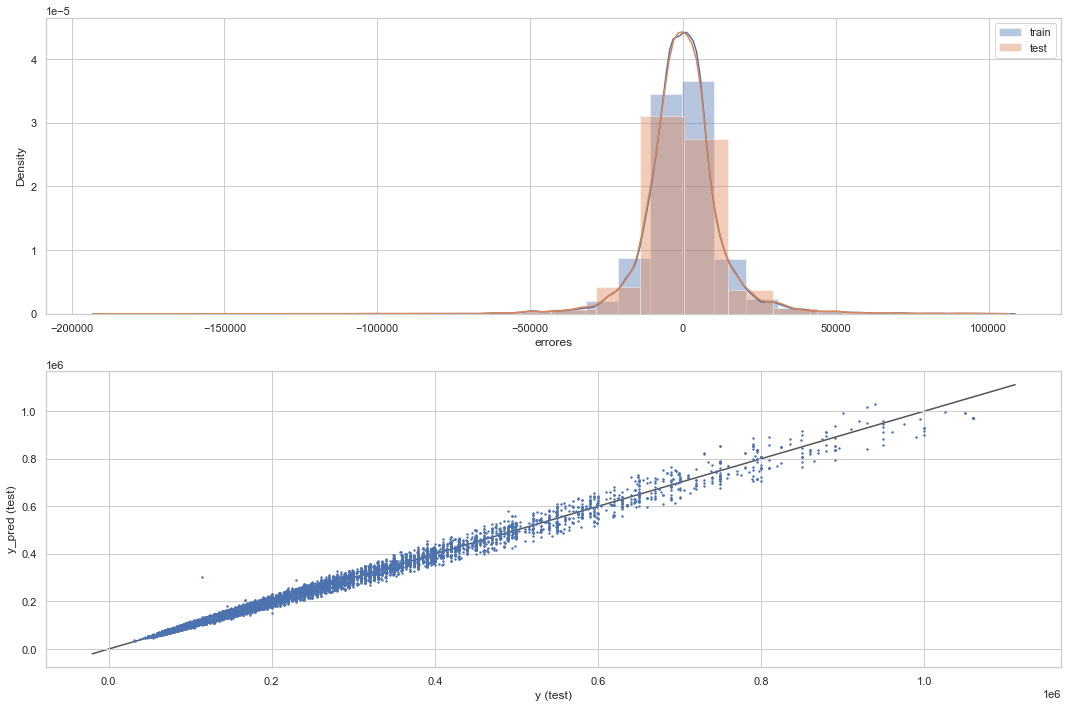

In [85]:
#Evaluamos el nuevo modelo
evaluar_regresion(reg_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

* Vemos que el error **mejoró** abrumadoramente.
* Las diferencias *train* vs. *test* son bajas, por lo que no hay presencia de **overfitting**.
* Generaliza y predice los datos de muy buena manera con un modelo sencillo.

## ML-Clustering
<a id='ML_Clustering'></a>

Por último, vamos a implementar un modelo de **clustering** para determinar si encontramos grupos de relaciones entre los datos:

* Usaremos el mismo concepto del preprocesamiento, donde buscaremos fijar una relación entre los barrios y el precio.
    * Para ello usaremos las variables `lat`,`lon` y la etiqueta `price`.


In [86]:
#1. Separamos las variables a utilizar
X_cluster=df5[['lat', 'lon']]
y_cluster=df5['price']

NameError: name 'df5' is not defined

In [ ]:
#2. Instanciamos el modelo
km = KMeans(n_clusters=3, random_state=42)

In [ ]:
#3. Entrenamos
km = km.fit(X_cluster)
km

In [ ]:
#4. Guardemos las etiquetas y los centroides obtenidos
etiquetas = km.labels_
centros = km.cluster_centers_

In [ ]:
#5. Graficamos
sns.scatterplot(X_cluster.iloc[:,0], X_cluster.iloc[:,-1], hue=etiquetas)
sns.scatterplot(centros[:,0], centros[:,1],color='black', marker="+", s=1000)
plt.title('Clusterización de datos y centroides', fontsize=15)
plt.show()

A primera vista no parece que la cantidad de clusters elegidos sea la óptima, por lo que utilizaremos el **método del codo** para determinar el mejor valor.

##### Método del Codo

In [ ]:
Sum_of_squared_distances = []
# Definimos la cantidad de clusters a probar y vamos fiteando un modelo con ellos
K = np.arange(2,20) 
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    # Calculamos la distancia media y agregamos a la lista
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,X.shape[0]) # no es necesario sacar el promedio, si hacemos el grafico con la inersia completa da igual
    Sum_of_squared_distances.append(distancia_media)

plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K', fontsize=10)
plt.ylabel('Inercia media',fontsize=10)
plt.title('Método del codo para el Dataset', fontsize=15, fontweight='black')

plt.show()

Si bien la curva presenta una caida suave podemos decir que la cantidad óptima de clusters se ubica entre **3** y **4**.
Para corroborar aplicaremos también el **método de silueta**.

##### Método de Silhouette

In [ ]:
# Calcularemos Silhouette para k igual a 3 4 6 8 y 10
# Definición del dataset de trabajo
X_std = X_cluster

lista_k = [3, 4, 6, 8, 10]

for i, k in enumerate(lista_k):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std.iloc[:, 0], X_std.iloc[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-12, 12])
    ax2.set_xlim([-12, 12])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

Con estos nuevos gráficos podemos entonces observar que la mejor opción para la clusterización es la división en **3** grupos.
* Esta medida está relacionada al mismo concepto aplicado en [3.2.3 Codificación de variables categóricas](#codificacion), donde se "clusterizó a mano" los distintos barrios según el precio promedio del metro cuadrado.